In [1]:
import os 
from tqdm import tqdm
import numpy as np
import glob
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

def transform_folder(folder, save_to):
    img = None
    files = list(glob.iglob(folder + "/*/*"))
    for file in tqdm(files):
        
        mat = np.load(file).transpose(1, 2, 0)
        to_save = "/".join([save_to] + file.split("/")[1:])
        os.makedirs("/".join(to_save.split("/")[:-1]), exist_ok=True)

        img = tf.keras.preprocessing.image.array_to_img(mat)
        plt.imshow(img)
        img.save(to_save.replace(".npy", ".png"))
    return img
        
img = transform_folder(os.path.join("dataset", "train"), os.path.join("dataset", "train_as_imgs"))

2023-03-15 15:24:32.600295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
100%|██████████| 30000/30000 [02:27<00:00, 203.32it/s]


Error in callback <function flush_figures at 0x7f566de5bb50> (for post_execute):


KeyboardInterrupt: 

100%|██████████| 7500/7500 [00:32<00:00, 228.65it/s]


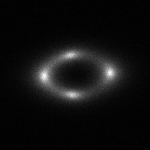

Error in callback <function flush_figures at 0x7f566de5bb50> (for post_execute):


KeyboardInterrupt: 

In [18]:
transform_folder(os.path.join("dataset", "val"), os.path.join("dataset", "val_as_imgs"))

In [26]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(os.path.join("dataset","train_as_imgs", "train"),
                                                    color_mode="grayscale", image_size=(150,150))
val_ds = tf.keras.preprocessing.image_dataset_from_directory(os.path.join("dataset","val_as_imgs", "val"),
                                                    color_mode="grayscale", image_size=(150,150))


Found 30000 files belonging to 3 classes.
Found 7500 files belonging to 3 classes.


In [32]:
import tensorflow
import tensorflow.keras as keras
from tensorflow.keras import layers

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(64, 1)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(64, 1)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(96, 2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(96, 2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(128, 3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(128, 3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(128, 3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(128, 3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(3, activation="sigmoid")(x)

    return keras.Model(inputs, outputs)

model = make_model(input_shape=(150, 150, 1), num_classes=1)
keras.utils.plot_model(model, show_shapes=True)
print(model.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_40 (Conv2D)          (None, 150, 150, 64)      128       
                                                                 
 batch_normalization_40 (Bat  (None, 150, 150, 64)     256       
 chNormalization)                                                
                                                                 
 activation_40 (Activation)  (None, 150, 150, 64)      0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 75, 75, 96)        2467

In [36]:
import tensorflow_addons as tfa
epochs = 25

BATCH_SIZE=64
steps_per_epoch = len(train_ds) // BATCH_SIZE

clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-3,
    maximal_learning_rate=2.5e-3,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)
optimizer = tf.keras.optimizers.Adam(clr)

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False,
                                                       ignore_class=None,
                                                       reduction="auto",
                                                       name="sparse_categorical_crossentropy"),
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    validation_data=val_ds)

Epoch 1/25
937/938 [============================>.] - ETA: 0s - loss: 1.1333 - accuracy: 0.3299

2023-03-15 15:49:40.533823: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-15 15:49:40.533879: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-15 15:49:41.099883: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-15 15:49:41.099933: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

938/938 [==============================] - 137s 142ms/step - loss: 1.1332 - accuracy: 0.3298 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 2/25
359/938 [==========>...................] - ETA: 1:16 - loss: 1.0987 - accuracy: 0.3339

KeyboardInterrupt: 